In [28]:
# ----------------- #
# Scarlet 1 testing #
# ----------------- #
# Import Packages and setup
import numpy as np
import pandas as pd
import cmasher as cmr
import scarlet 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rc('image', cmap=cmr.cosmic, interpolation='none', origin='lower')
#plt.style.use('dark_background')

plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [29]:
data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
data = df[df['parent_ID']==df['parent_ID'][4000]] #4000 

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_filters = np.array([np.array(data['mask_g'])[0] , np.array(data['mask_r'])[0]  , np.array(data['mask_i'])[0]  , 
                        np.array(data['mask_y'])[0]  , np.array(data['mask_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

In [30]:
# Load the sample images
images = multi_images 
weights = 1/multi_var 
filters = np.array(['g','i','r','y','z'],dtype='<U1') # explicitly make filter list
centers = np.array( data['loc'] )
psf = scarlet.ImagePSF( multi_psf )

In [31]:
# from scarlet.display import AsinhMapping
# stretch = 0.2
# Q = 10
# norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
# img_rgb = scarlet.display.img_to_rgb(images)
# plt.imshow(img_rgb)
# plt.title('HSC raw observation with PSF', fontsize=24)
# plt.show()

In [32]:
model_psf = scarlet.GaussianPSF(sigma=(0.7,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)

In [33]:
sources, skipped = scarlet.initialization.init_all_sources( model_frame,
                                                            centers,
                                                            observation,
                                                            max_components=1,
                                                            min_snr=5,
                                                            thresh=1,
                                                            fallback=True,
                                                            silent=True,
                                                            set_spectra=True
                                                            )

In [34]:
# alter spectrum values
for i in range(len(sources[0].parameters[0])):
    sources[0].parameters[0][i] = sources[0].parameters[0][i] * 10
    
# fix the step size
sources[0].parameters[0].step = 1e-1
sources[0].parameters[1].step = 1e-1

# store the spectrum and morphology for Scarlet 2 initialisation
spectrum_init = sources[0].spectrum.get_model()
morph_init = sources[0].parameters[1] 

CPU times: user 340 ms, sys: 8.58 ms, total: 349 ms
Wall time: 348 ms
scarlet ran for 200 iterations to logL = 217.07956686960824


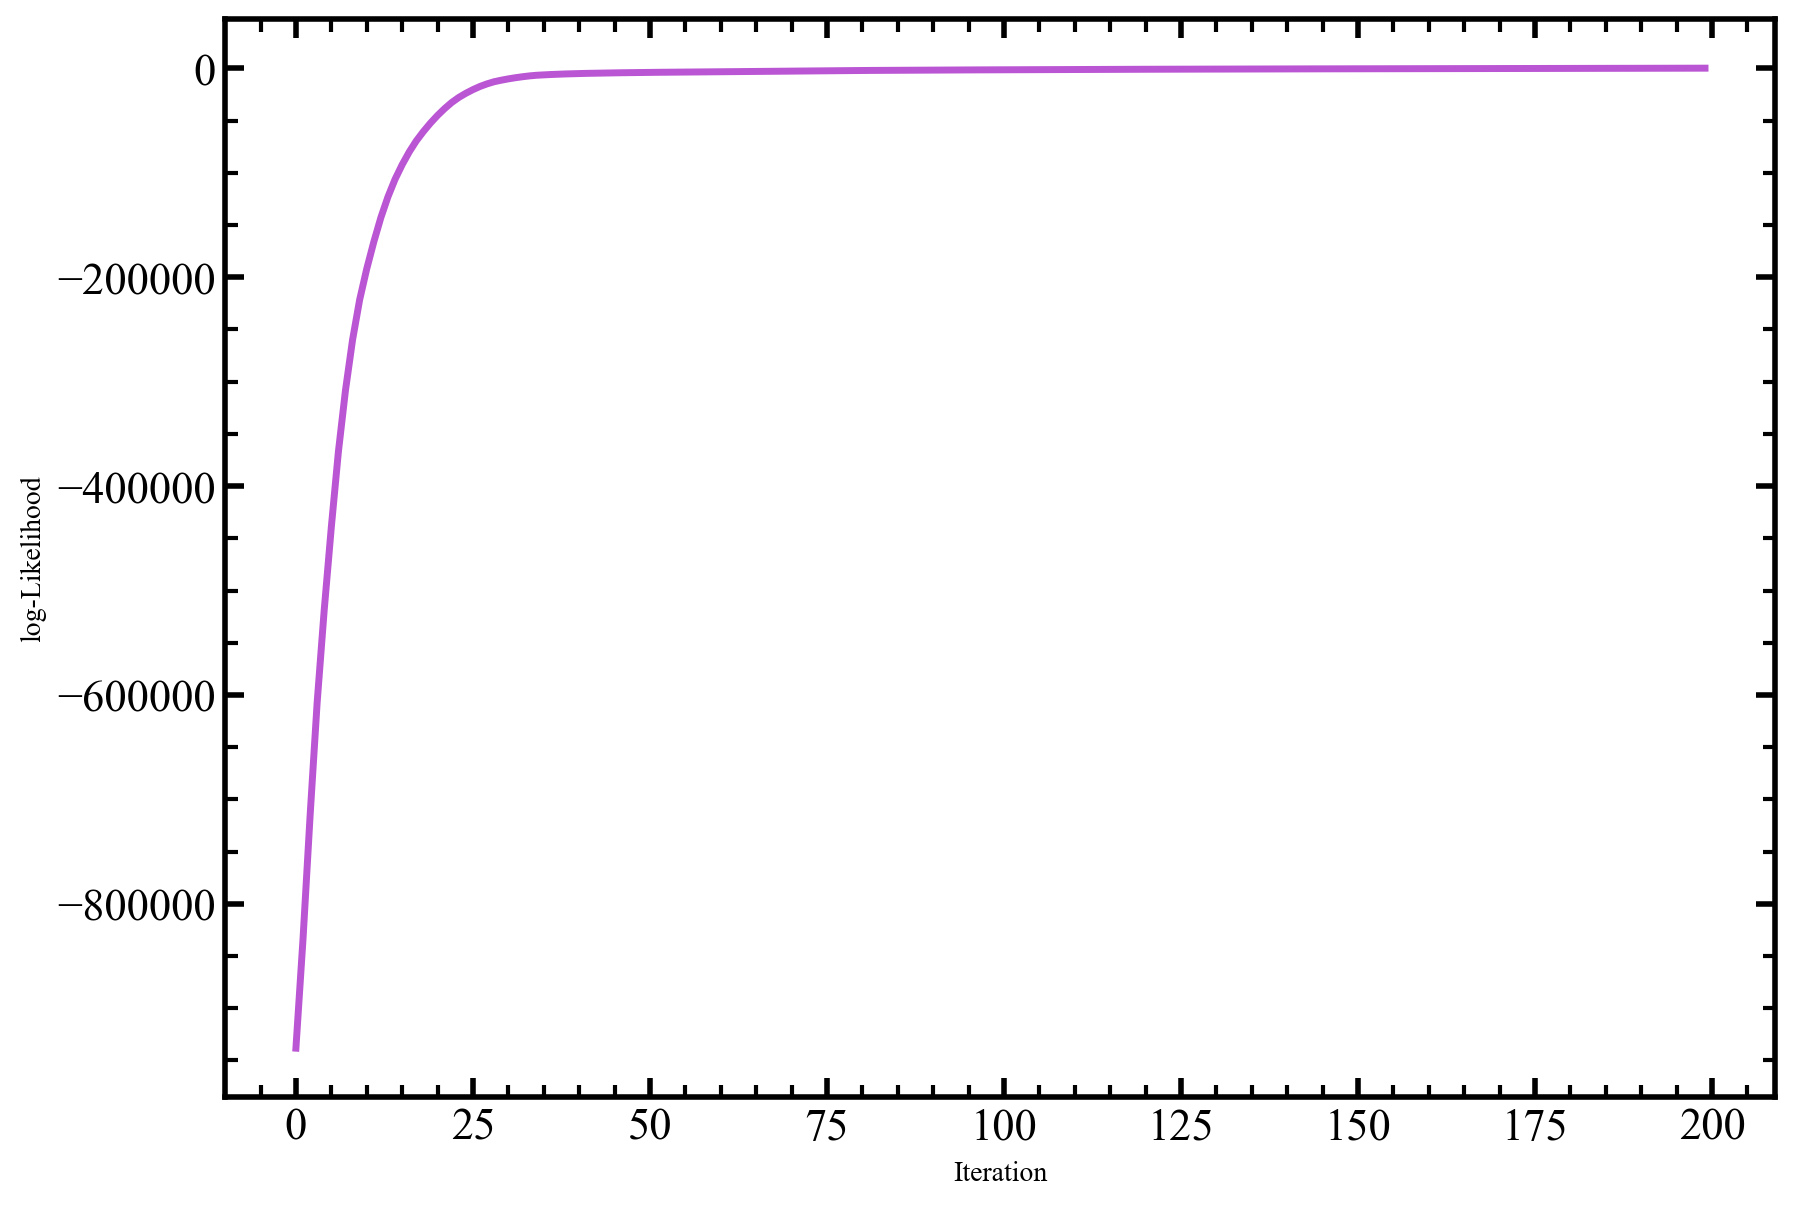

In [35]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(200, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

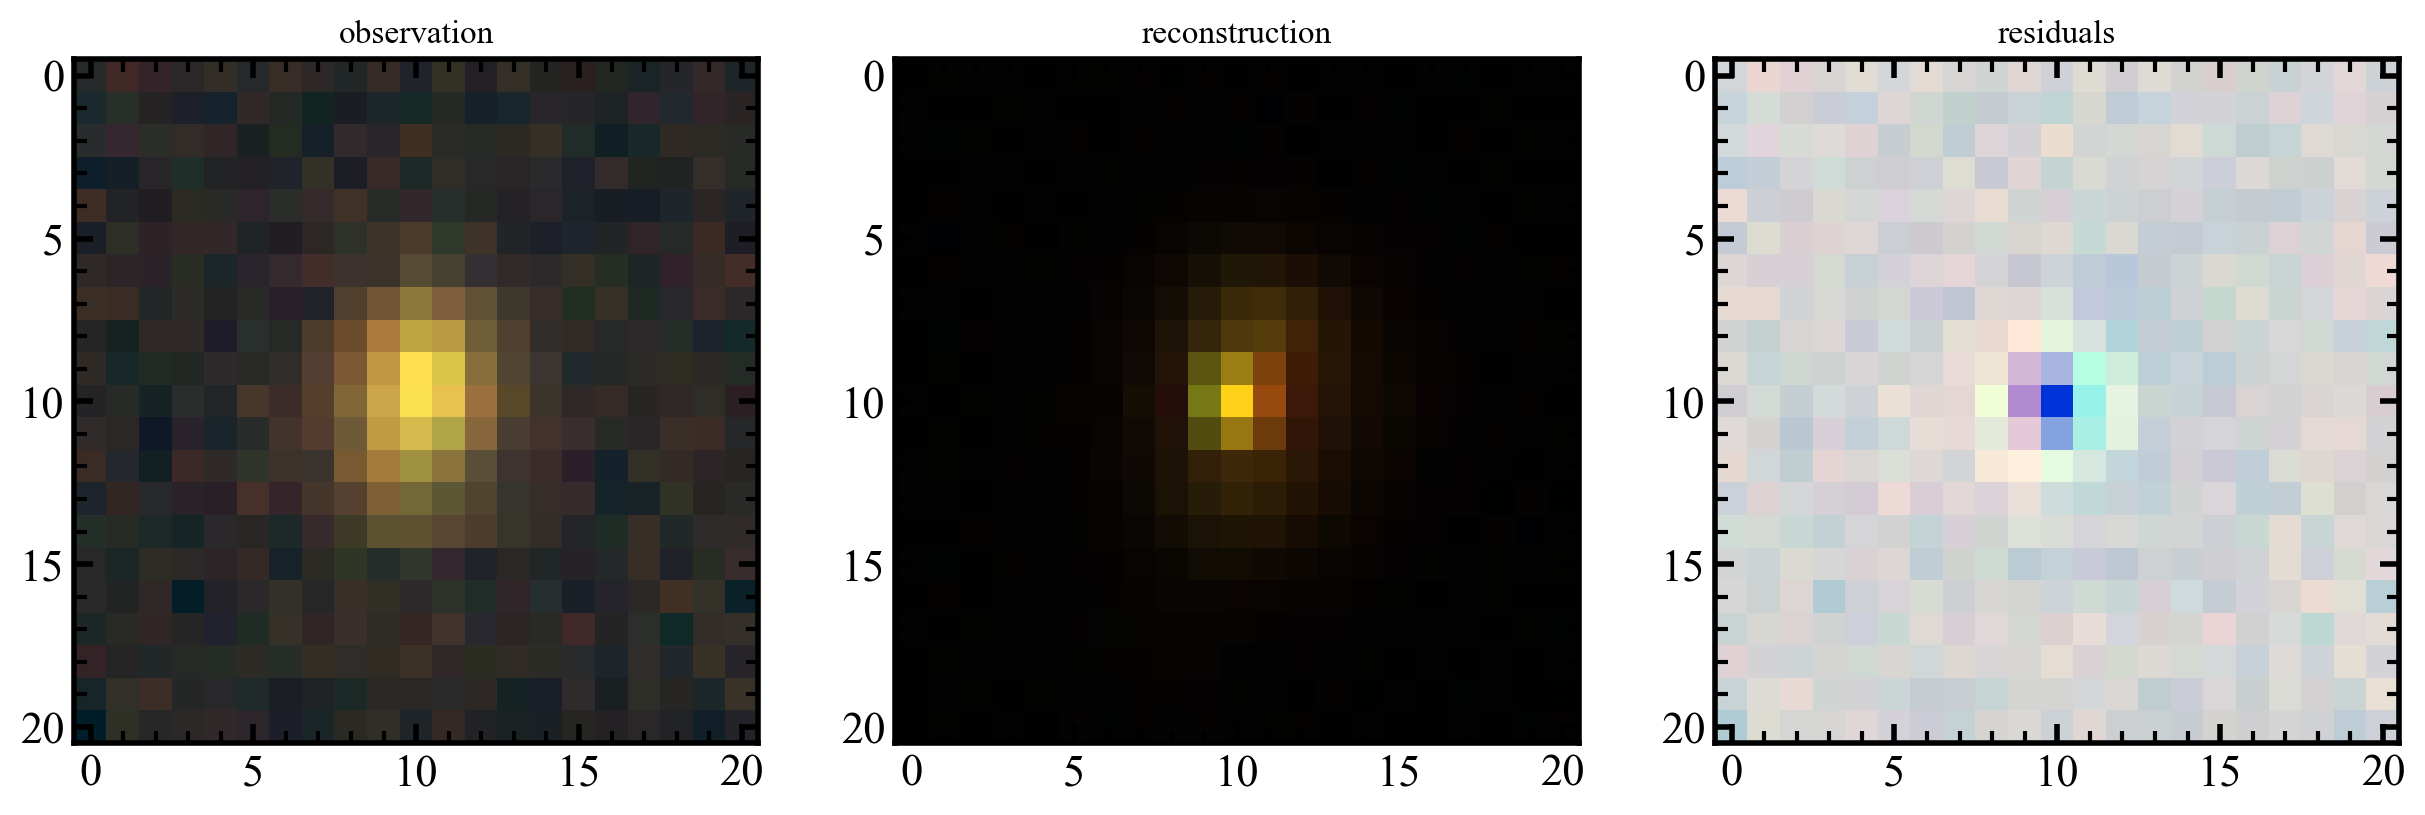

In [36]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# Create RGB images
model_raw_rgb = scarlet.display.img_to_rgb(model)#, norm=norm)
model_rgb = scarlet.display.img_to_rgb(model_)#, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)
observation_rgb = scarlet.display.img_to_rgb(observation.data)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(observation_rgb,cmap=cmr.sepia)
ax[0].set_title("observation")
ax[1].imshow(model_rgb,cmap=cmr.sepia)
ax[1].set_title("reconstruction")
ax[2].imshow(residual_rgb,cmap=cmr.sepia)
ax[2].set_title("residuals")
plt.show()

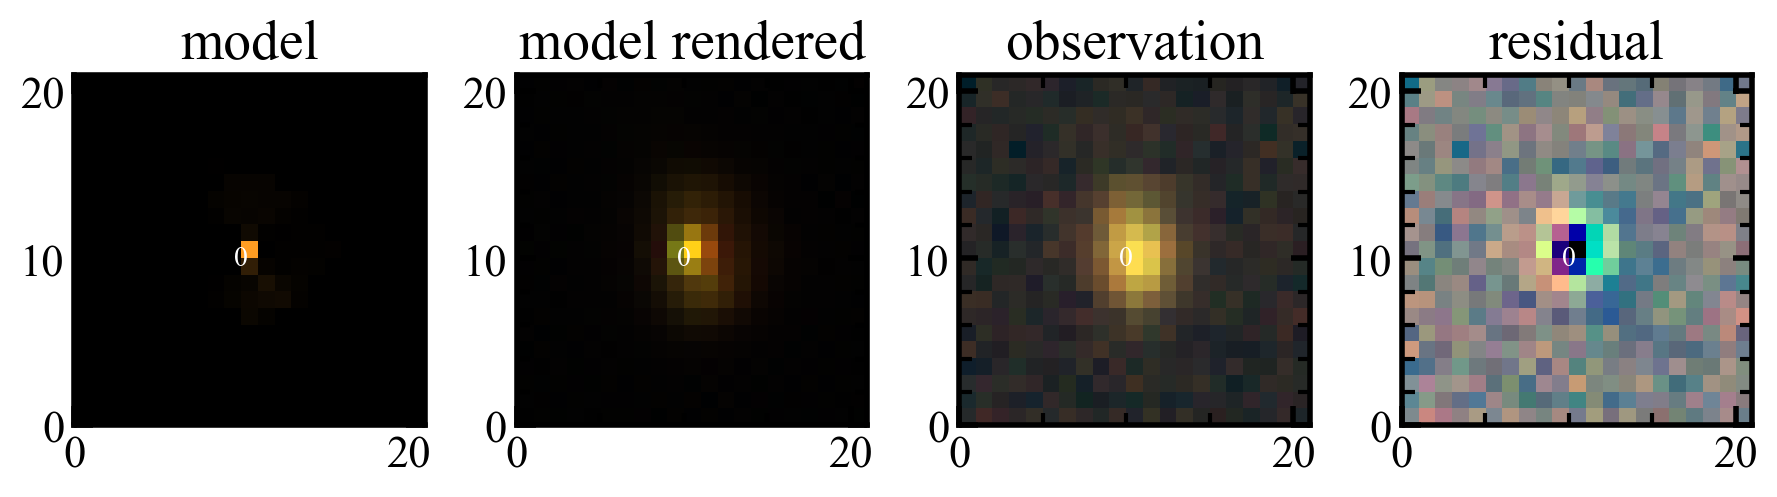

In [37]:

scarlet.display.show_scene(sources,
                           norm=None,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(9,3))
plt.subplot(1,4,1)
plt.title('model', fontsize=20)
#plt.axis('off')
plt.subplot(1,4,2)
plt.title('model rendered', fontsize=20)
#plt.axis('off')
plt.subplot(1,4,3)
plt.title('observation', fontsize=20)
#plt.axis('off')
plt.subplot(1,4,4)
plt.title('residual', fontsize=20)
#plt.axis('off')
plt.savefig('scarlet1.pdf',facecolor='white',transparent=False ,dpi = 300)
plt.show()


In [38]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

# Create greyscale images
model_raw_grey = rgb2gray(model_raw_rgb)
obs_grey       = rgb2gray(observation_rgb)
model_grey     = rgb2gray(model_rgb)
residual_grey  = rgb2gray(residual_rgb)

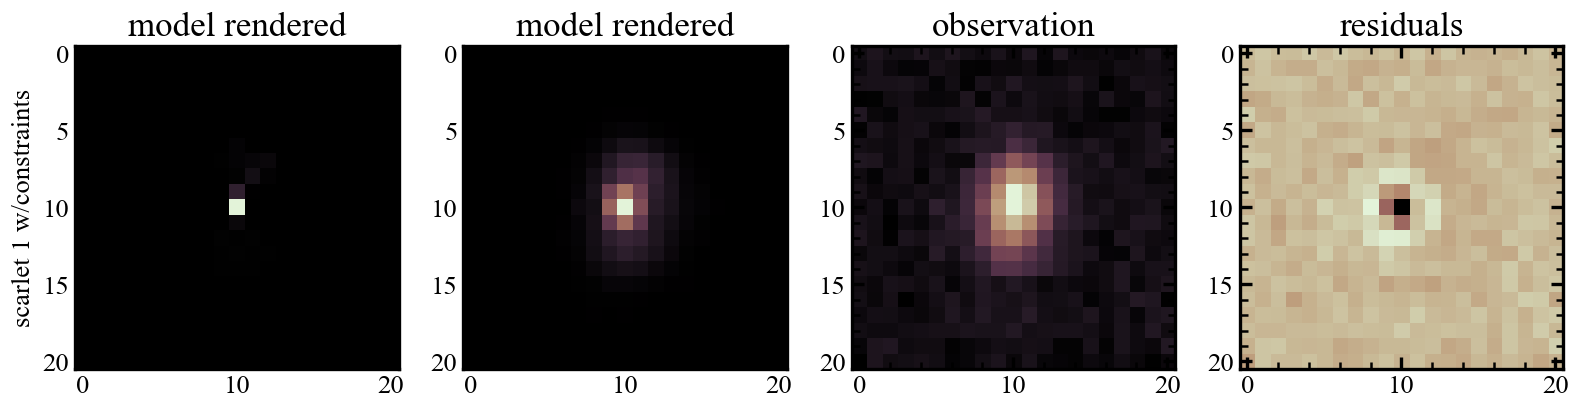

In [39]:
# Show the data, model, and residual
fig, ax = plt.subplots(1, 4, figsize=(16,3.5),dpi=120)
ax[0].imshow(model_raw_grey,cmap=cmr.sepia)
ax[0].set_title("model rendered" ,fontsize = 21)
ax[0].set_ylabel('scarlet 1 w/constraints', fontsize = 16)
ax[1].imshow(model_grey,cmap=cmr.sepia)
ax[1].set_title("model rendered", fontsize = 21)
ax[2].imshow(obs_grey,cmap=cmr.sepia)
ax[2].set_title("observation", fontsize = 21)
ax[3].imshow(residual_grey,cmap=cmr.sepia)
ax[3].set_title("residuals", fontsize = 21)
#fig.tight_layout()
plt.savefig('bad_init_test_scar1.png', dpi=120)
plt.show()

In [40]:
np.save('/Users/mattsampson/Princeton/SampsonMelchior/neural_scarlet/scarlet2/scarlet1_model.npy',model_raw_grey)
np.save('/Users/mattsampson/Princeton/SampsonMelchior/neural_scarlet/scarlet2/scarlet1_render.npy',model_grey)
np.save('/Users/mattsampson/Princeton/SampsonMelchior/neural_scarlet/scarlet2/scarlet1_obs.npy',obs_grey)
np.save('/Users/mattsampson/Princeton/SampsonMelchior/neural_scarlet/scarlet2/scarlet1_resid.npy',residual_grey)
np.save('/Users/mattsampson/Princeton/SampsonMelchior/neural_scarlet/scarlet2/scarlet1_spectrum.npy',spectrum_init)
np.save('/Users/mattsampson/Princeton/SampsonMelchior/neural_scarlet/scarlet2/scarlet1_morph.npy',morph_init)